## Analysis of EVI Trend Break Magnitudes with XGBRegressor - v1

Peter R., 2023-09-10

### Intro
There are several way to carry our Extreme Gradient Boosting (XGB). Here I use XGBRegression() to analyze forest EVI breaks (both negative & positive breaks) together.

Here I try to answer the question: What factors predict EVI (negative and positive) Trend Break magnitude?

Note that driver data have been assigned here by using spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data.  An important missing driver is likely tree windthrow.

This is a simplified version of v5 meant to be run on DRAC. In this version I leave out climate moisture index as it is very correlated with precipitation.  Here the CSV has timber value variables but won't be part of the main model this time.

#### File and folder path settings

In [1]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\github\forc_trends\models\xgboost


#### Load and explore the data

In [2]:
import pandas as pd
#from pandas import read_csv
from numpy import nan

# Windows path
#df1 = pd.read_csv(r'.\data\forest_evi_breaks_sam3.csv', skipinitialspace=True)

# Drac path
df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
df1.head()


,year,magnitude,age,deciduous,conifers,protected,elevation,precipitation,temperature,precipitation_lag1,...,cmi_lag2,rh_lag2,cmi_lag3,rh_lag3,merch_vol,lumber,lumber_lag1,lumber_lag2,lumber_lag3,rid
0,2004,179.4,48.54,39.9,59.363,0,292,793.0,3.22,945,...,31.0,58.0,31.8,58.0,160.67,99.0,89.1,92.1,92.6,1
1,2004,359.2,48.70,34.4,65.525,0,321,799.0,3.11,952,...,32.0,58.0,32.8,58.0,243.24,99.0,89.1,92.1,92.6,2
2,2004,631.7,54.46,47.6,52.067,0,308,797.0,3.20,949,...,31.5,58.0,32.2,58.0,169.77,99.0,89.1,92.1,92.6,3
3,2004,514.6,40.27,26.5,72.711,0,309,796.0,3.20,949,...,31.5,58.0,32.2,58.0,179.97,99.0,89.1,92.1,92.6,4
4,2004,798.4,57.42,51.4,48.625,0,338,796.0,3.15,953,...,31.6,58.0,32.1,58.0,229.52,99.0,89.1,92.1,92.6,5


In [2]:
#df1.tail()

In [3]:
# note: in this test data set, protected has a single value. Hence, get_dummies does not work as expected
df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)
#df2 = pd.get_dummies(df1, columns=['year', 'protected'], dtype=float)

#df2.head()


In [5]:
#print(df2.describe)

# Remove records where precipitation is null
df2= df2[df2['precipitation'].notna()]
print(df2.describe)
#[788 rows x 24 columns]

<bound method NDFrame.describe of       year  magnitude    age  deciduous  conifers  elevation  precipitation  \
0     2004      179.4  48.54       39.9    59.363        292          793.0   
1     2004      359.2  48.70       34.4    65.525        321          799.0   
2     2004      631.7  54.46       47.6    52.067        308          797.0   
3     2004      514.6  40.27       26.5    72.711        309          796.0   
4     2004      798.4  57.42       51.4    48.625        338          796.0   
...    ...        ...    ...        ...       ...        ...            ...   
3888  2021      754.5  85.06       44.3    53.420        340         1091.0   
3889  2021      856.2  83.77       46.6    51.913        342         1091.0   
3890  2021      947.4  90.66       86.6    13.362        418         1095.0   
3891  2021      909.8  84.86       88.2    11.827        413         1095.0   
3892  2021      939.0  86.38       88.2    10.638        369         1093.0   

      temperature

In [6]:
#df2.tail()

#pd.to_numeric(df2)

# check data types
print(df2.dtypes)


year                    int64
magnitude             float64
age                   float64
deciduous             float64
conifers              float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
cmi                   float64
rh                    float64
cmi_lag1              float64
rh_lag1               float64
cmi_lag2              float64
rh_lag2               float64
cmi_lag3              float64
rh_lag3               float64
merch_vol             float64
lumber                float64
lumber_lag1           float64
lumber_lag2           float64
lumber_lag3           float64
rid                     int64
protected_0           float64
protected_1           float64
dtype: object


In [21]:
# split data into input and output columns
#from numpy import absolute

X1 = df2.iloc[:,2:30]
# conifers & deciduous are highly negatively correlated. I drop conifers
# Also, precipitation is correlated with CMI. I will drp cmi, cmi_lag1, cmi_lag2, cmi_lag3. Also, I will drop rh_lag3
X1.drop(X1.columns[[2,12, 14, 16, 18,19, 20,21,22,23,24,25]], axis=1,inplace=True)
#print(X1.head())

#df[list(df.columns[:2]) + [7]]

#print(X1.describe)
#print(X1.dtypes)



In [22]:
# check data types
print(X1.dtypes)

age                   float64
deciduous             float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
rh                    float64
rh_lag1               float64
rh_lag2               float64
protected_0           float64
protected_1           float64
dtype: object


In [8]:
# I will run a correlation plot with X2
#X2 = X1

#X2.drop(X2.columns[[15,16]], axis=1,inplace=True)
#print(X2.describe)
#print(X2.dtypes)


In [23]:
y1 = df2.iloc[:,1]
print("Response/label data")
print(y1.head())

#print("Response/label data, Absolute value of Negative break magnitude")
#y2 = absolute(y1)
#print(y2.head())

#X, y = df2[:, :-1], df2[:, -1]
#X.head()

Response/label data
0    179.4
1    359.2
2    631.7
3    514.6
4    798.4
Name: magnitude, dtype: float64


In [64]:
#print(X1.head())

age                   float64
deciduous             float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
rh                    float64
rh_lag1               float64
rh_lag2               float64
dtype: object


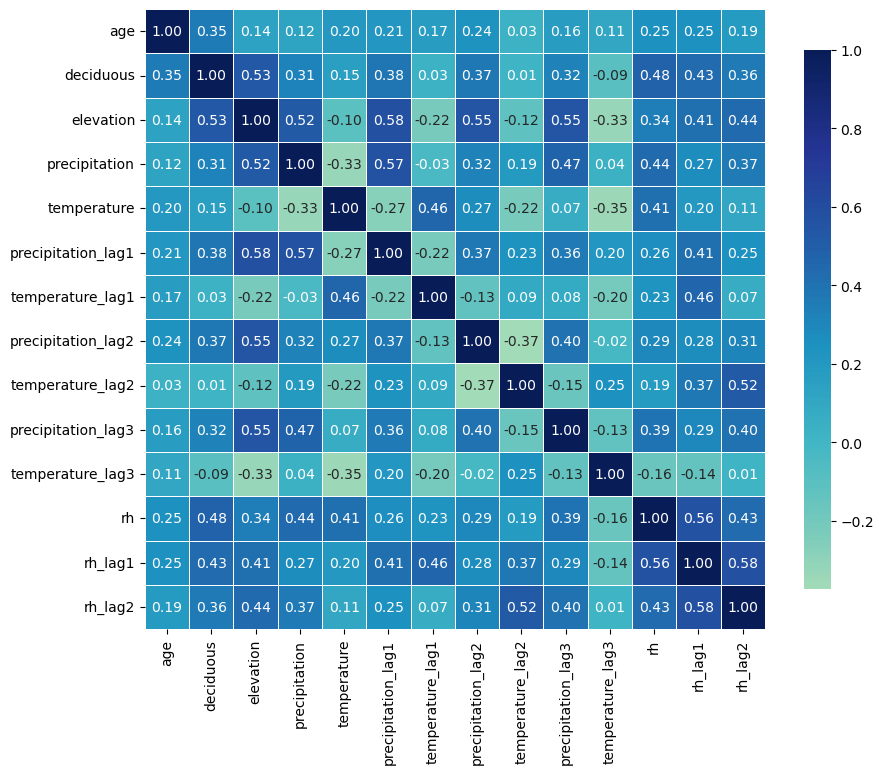

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

X2 = X1.iloc[:,0:14] # Remove protected status vars

print(X2.dtypes)

def correlation_heatmap(X2):
    correlations = X2.corr()
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )

    plt.show();

#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3","protected_0","protected_1",
#                 "cmi", "rh" ,"cmi_lag1", "rh_lag1","cmi_lag2", "rh_lag2","cmi_lag3", "rh_lag3"]

features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2"]

correlation_heatmap(X2[features_names1])

#plt.savefig('correlation5.png',  dpi=300, bbox_inches='tight')


plt.show()

In [27]:
# timber data set
# split data into input and output columns
#from numpy import absolute

X1 = df2.iloc[:,2:30]
# conifers & deciduous are highly negatively correlated. I drop conifers
# Also, precipitation is correlated with CMI. I will drp cmi, cmi_lag1, cmi_lag2, cmi_lag3. Also, I will drop rh_lag3
X1.drop(X1.columns[[2,12, 14, 16, 18,19,25]], axis=1,inplace=True)

In [28]:
print(X1.dtypes)

age                   float64
deciduous             float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
rh                    float64
rh_lag1               float64
rh_lag2               float64
merch_vol             float64
lumber                float64
lumber_lag1           float64
lumber_lag2           float64
lumber_lag3           float64
protected_0           float64
protected_1           float64
dtype: object


In [30]:
print(X1.describe)

<bound method NDFrame.describe of         age  deciduous  elevation  precipitation  temperature  \
0     48.54       39.9        292          793.0         3.22   
1     48.70       34.4        321          799.0         3.11   
2     54.46       47.6        308          797.0         3.20   
3     40.27       26.5        309          796.0         3.20   
4     57.42       51.4        338          796.0         3.15   
...     ...        ...        ...            ...          ...   
3888  85.06       44.3        340         1091.0         6.84   
3889  83.77       46.6        342         1091.0         6.82   
3890  90.66       86.6        418         1095.0         6.43   
3891  84.86       88.2        413         1095.0         6.46   
3892  86.38       88.2        369         1093.0         6.68   

      precipitation_lag1  temperature_lag1  precipitation_lag2  \
0                    945              3.29                 825   
1                    952              3.18           

#### Set up & run model

Here the model evaluation metric is mean absoulte error. Other metrics are available for regression.


In [29]:
# evaluate an xgboost regression model on the housing dataset
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

print("XGB version:", xgb.__version__)

# split data into input and output columns
#X, y = df2[:, :-1], df2[:, -1]

seed = 7 # random seed to help with replication
testsize1 = 0.2 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

# set custom parameters rather than use defaults
# 'reg:linear', reg:squarederror
param = {
    'max_depth': 4,  # tree complexity, tree depth
    'eta':0.3,  # learning rate
    'objective': 'reg:squarederror'  #minimize sqaured error
   
}

#epochs = 10 # no longer needed, used with train()


# define model
model_m2a = XGBRegressor(set_params=param)

# n_estimators is the number of trees
print(model_m2a)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) # 289.996 (52.529), Mean MAE: 288.345 (51.031); Mean MAE: 561.678 (63.102)
# 543.457 (58.644)
# 537.123 (69.883)
# 529.372 (69.402)


XGB version: 1.7.6
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Mean MAE: 223.472 (12.787)


In [32]:
# evaluate model with mean square error
#scores2 = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
#scores2 = absolute(scores)
#print('Mean MSE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) ) # Mean MSE: 289.996 (52.529); 288.345 (51.031); Mean MSE: 577.740 (58.160), Mean MSE: 561.678 (63.102)

# Mean MSE: 543.457 (58.644)
# Mean MSE: 537.123 (69.883)



In [33]:
import statistics

# evaluate model with variance explained
scores3 = cross_val_score(model_m2a, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.102 (0.466)

#Mean Var. Explained: 0.091 (0.130)
#Mean Var. Explained: 0.110 (0.160)
    

[0.27474017 0.29245529 0.31531189 0.45309685 0.34119812 0.27072053
 0.2403877  0.2438739  0.35015056 0.19128125 0.2184859  0.37834175
 0.35922446 0.25584244 0.20413068 0.42687379 0.28871363 0.25488102
 0.24917372 0.28278119 0.34359894 0.38332257 0.19161626 0.39056981
 0.42068574 0.26462671 0.40840791 0.33478943 0.20301839 0.34954427]
0.30606149581535197
Mean Var. Explained: 0.306 (0.074)


In [34]:
# R-squared
# evaluate model with variance explained
scores4 = cross_val_score(model_m2a, x1_train, y1_train, scoring='r2', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('R-sq: %.3f (%.3f)' % (scores4.mean(), scores4.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.102 (0.466)

#R-sq: 0.076 (0.136)
# R-sq: 0.097 (0.162)



R-sq: 0.303 (0.074)


#### Fine tunning parameters
Fine tune parameters to find a better model (potentially). 

In [35]:
# Fine tune parameters using GridSearchCV (for exhaustive searches) or RandomizedSearchCV (faster)
# max_depth is tree complexity in Elith et al. 2008
# n_estimators=100 is the number of trees. Elith et al. 2008 say this should be 1000 at least
# Elith et al. 2008 suggests low learning rate

# evaluate an xgboost regression model on the housing dataset
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

print("XGB version:", xgb.__version__)

# split data into input and output columns
#X, y = df2[:, :-1], df2[:, -1]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

# Take 1
from sklearn.model_selection import RandomizedSearchCV

# Fine tunning parameters with Random Search
#search space
params_xgboost = {
 "learning_rate"    : [ 0.001, 0.005, 0.01, 0.05, 0.10, 0.15],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10],
 "gamma"            : [ 0.0, 0.01, 0.05, 0.1, 0.2, 0.3],
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
'n_estimators'     : [1000],
 'objective': ['reg:squarederror'],
#'early_stopping_rounds': [10]
# reg_alpha provides L1 regularization to the weight, higher values result in more conservative models
"reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
# reg_lambda provides L2 regularization to the weight, higher values result in more conservative models
"reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

model_base1 = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_base1, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=10, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                        refit=True,
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train)

#random_search
print(random_search.best_params_)
print(random_search.best_estimator_)



XGB version: 1.7.6
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'reg_lambda': 10, 'reg_alpha': 1e-05, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [37]:
# Optimal model according to random search. early_stopping_rounds conflicts with cross_val_score
# when I run the model with all the dat then use early_stopping_rounds=10
model_m2e = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=["error", "logloss"], feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_lambda= 10, reg_alpha= 1e-05 )

# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
#scores = cross_val_score(model_m2e, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) #Mean MAE: 555.691 (50.281)
#Mean MAE: 566.044 (56.495); 526.541 (62.535)

# Mean MAE: 527.065 (60.386)
# Mean MAE: 511.496 (61.699)
# Mean MAE: 526.682 (68.147)
# Mean MAE: 223.472 (12.787) with timber

Mean MAE: 223.472 (12.787)


In [40]:
# evaluate model with variance explained
#scores3 = cross_val_score(model_m2e, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
#print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)
# Variance explained is more than model_m2c. Model_m2d seems better.
# nulls out: Mean Var. Explained: 0.218 (0.121), model_m2c explain more
# Mean Var. Explained: 0.186 (0.114)
# Mean Var. Explained: 0.143 (0.132)


#### Evaluation

In [39]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_m2e.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_m2e.predict(x1_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y1_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model_m2e.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
#x_axis = range(0, 100)

mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)


MSE: 108534.31
RMSE: 329.45
R-sq: 0.31


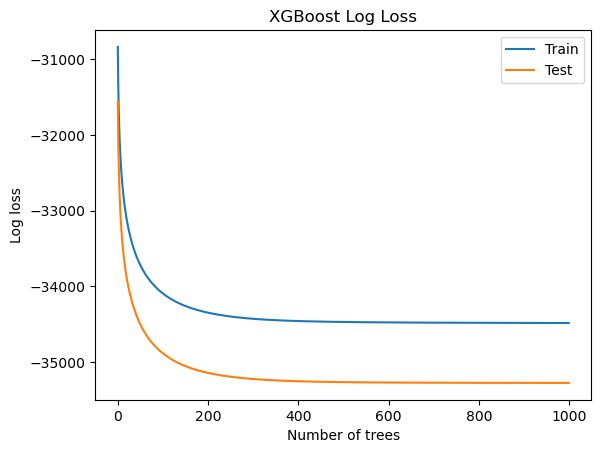

In [41]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(67, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Log loss")
pyplot.title('XGBoost Log Loss')
pyplot.legend()
pyplot.show()

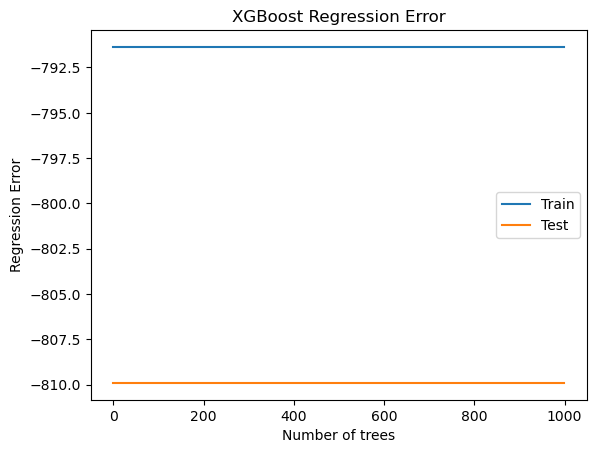

In [42]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
pyplot.xlabel("Number of trees")
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

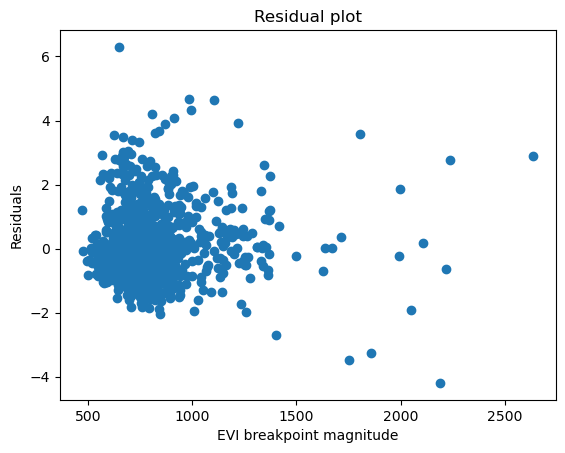

In [43]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')

pyplot.show()

#### Model plots

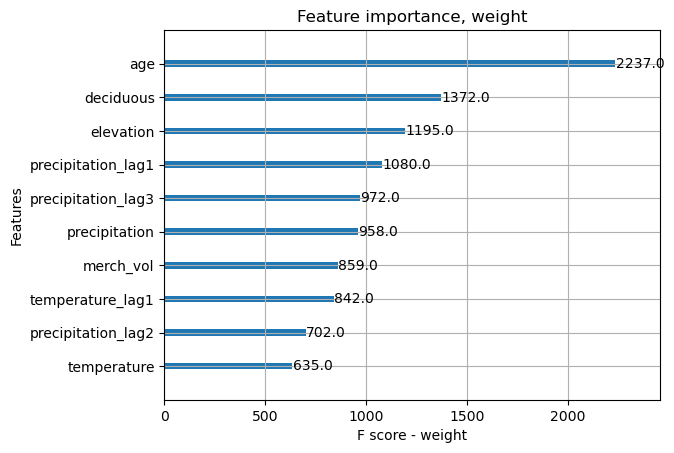

In [44]:
# Feature importance plots

xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, weight', 
                    xlabel='F score - weight', ylabel='Features', 
                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

pyplot.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.

# F score: This is a metric that simply sums up how many times each feature is split on

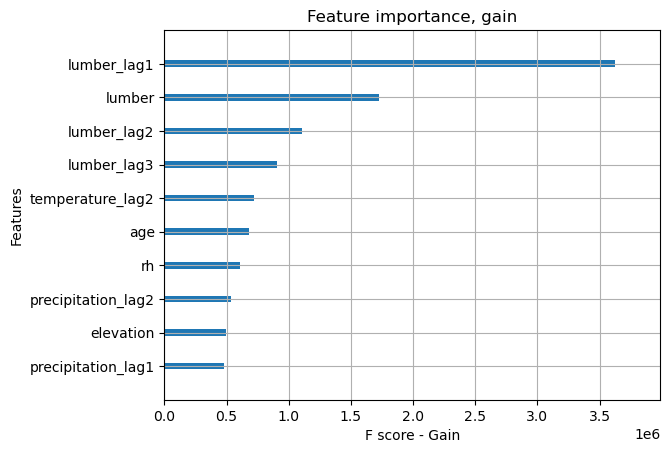

In [45]:
# Plot, metric: gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

#pyplot.savefig('gain5.png',  dpi=300, bbox_inches='tight')


pyplot.show()

In [35]:
# Plot, metric: cover
#xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, cover', 
#                    xlabel='F score - Cover', ylabel='Features', 
#                    importance_type='cover', max_num_features=10, grid=True, show_values=False)

#pyplot.show()


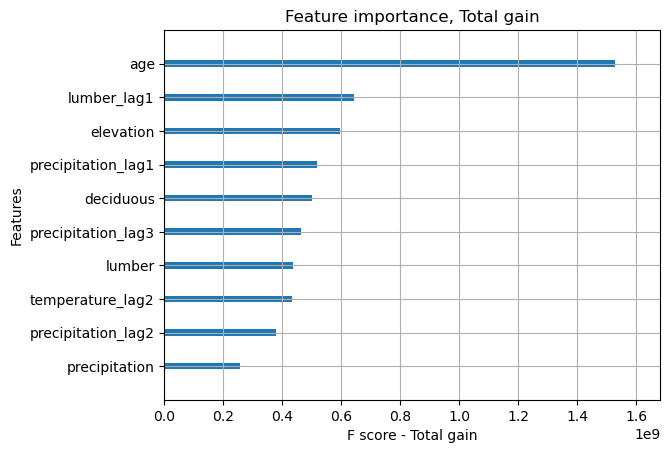

In [46]:
# Plot, metric: total gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total gain', 
                    xlabel='F score - Total gain', ylabel='Features', 
                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

#pyplot.savefig('total_gain5.png',  dpi=300, bbox_inches='tight')

pyplot.show()

In [37]:
# Plot, metric: total cover
#xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total cover', 
#                    xlabel='F score - Total cover', ylabel='Features', 
#                    importance_type='total_cover', max_num_features=10, grid=True, show_values=False)

#pyplot.show()

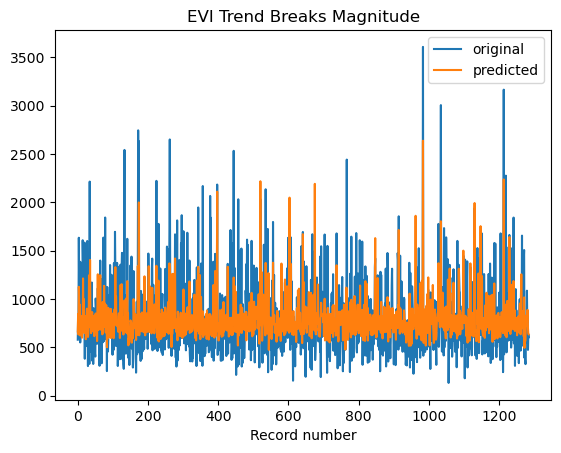

In [47]:
import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

plt.title("EVI Trend Breaks Magnitude")

plt.legend()

#plt.savefig('original_vs_predicted5.png',  dpi=300, bbox_inches='tight')

plt.show()

In [40]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
#import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

#xgb.to_graphviz(model_m2e, num_trees = 1) #num_trees = model_m2e.best_iteration


In [39]:
# this works for saving graphviz
#format = 'png' #You should try the 'svg'

#image = xgb.to_graphviz(model_m2e, num_trees = model_m2e.best_iteration)

#Set a different dpi (work only if format == 'png')
#image.graph_attr = {'dpi':'300'}

#image.render('decision_tree5', format = format)


In [43]:
# More plots
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree, plotting

#import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
#import graphviz
#import matplotlib.pyplot as plt
#from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

#features_names1 = ["age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]

#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3","protected_0","protected_1"]
#target_names1 = "Magnitude"

# tree max is # after "stop early"
#tree_index=1,
#viz_rmodel = dtreeviz.model(model=model_m2e, tree_index=model_m2e.best_iteration, 
#                            X_train=x1_train, 
#                            y_train=y1_train, 
#                            feature_names=features_names1, 
#                            target_name=target_names1)


#viz_rmodel.view()

#v = viz_rmodel.view()     # render as SVG into internal object 
#v.show()                 # pop up window
#v.save("decision_tree_treeviz.svg")  # optionally save as svg

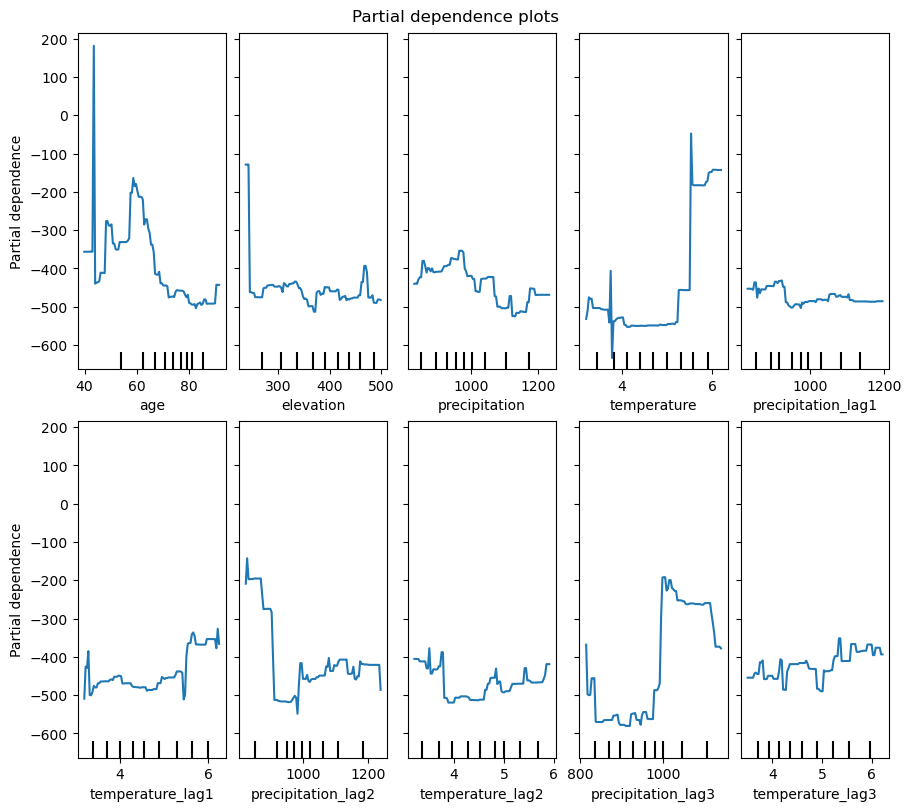

In [44]:
# Not run
# Partial dependence plots
# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

features_names2 = ["age","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_m2e, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig('partial_dependence5.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles


In [41]:
# Individual Effect Plot (ICE)
#_, ax1 = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

#common_params = {
#    "subsample": 50,
#    #"n_jobs": 2,
#   # "grid_resolution": 20,
#   # "random_state": 0,
#}

#features_info = {
#    "features": ["age", "temperature"],
#    "kind": "both",
#    "centered": True,
#}

#display = PartialDependenceDisplay.from_estimator(
#    model_m2e,
#    x1_train,
#    **features_info,
#    ax=ax1,
#    **common_params,
#)

#_ = display.figure_.suptitle("ICE and PDP representations", fontsize=12)

In [45]:
# 2D interaction plots
#_, ax1 = plt.subplots(ncols=1, figsize=(6, 4), sharey=True, constrained_layout=True)

#common_params = {
#    "subsample": 50,
#    #"n_jobs": 2,
#   # "grid_resolution": 20,
#   # "random_state": 0,
#}

#features_info = {
#    "features": [ ("precipitation_lag3", "age")],
#    #"kind": "both",
#    "kind": "average",
#    #"centered": True,
#}

#display = PartialDependenceDisplay.from_estimator(
#    model_m2e,
#    x1_train,
#    **features_info,
#    ax=ax1,
#   # **common_params,
#)

#_ = display.figure_.suptitle("2-way of numerical PDP", fontsize=12)

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


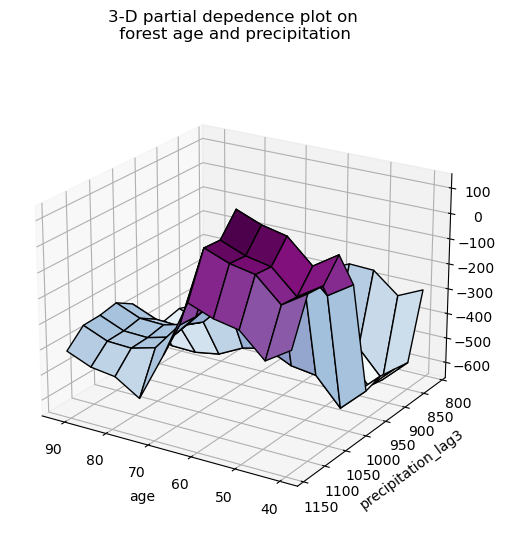

In [48]:
# 3D plot
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(6.5,6))

features = ("age", "precipitation_lag3")

pdp = partial_dependence(
    model_m2e,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n forest age and precipitation",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

#plt.savefig('3d_partial_dependence5.png',  dpi=300, bbox_inches='tight')

plt.show()

In [49]:
# save in JSON format
model_m2e.save_model("model_m2e_regression1.json")
# save in text format
#model_m2.save_model("model_m2.txt")


In [ ]:
# load saved model
#model2 = xgb.Regressor()
#model2.load_model("model_regression1.json")


#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

https://scikit-learn.org/stable/modules/partial_dependence.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#way-partial-dependence-with-different-models

https://mljar.com/blog/xgboost-early-stopping/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://github.com/parrt/dtreeviz



